In [1]:
#This is for analyzing layer data 

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import yaspy
import scipy
import pyvista as pv
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import brainspace.gradient.alignment as ga

pv.start_xvfb()

#schaefer
atlas_schaefer100 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_100Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)
atlas_schaefer400 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_400Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)
atlas_schaefer1000 = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_1000Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)


#glasser
'''
atlas_path_R = '/Users/dennis.jungchildmind.org/Downloads/Glasser_2016.32k.R.label.gii'
atlas_R = nib.load(atlas_path_R).darrays[0].data
atlas_path_L = '/Users/dennis.jungchildmind.org/Downloads/Glasser_2016.32k.L.label.gii'
atlas_L = nib.load(atlas_path_L).darrays[0].data
atlas = np.concatenate([atlas_L, atlas_R])
'''
#Desikan
'''
atlas_path_R = '/Users/dennis.jungchildmind.org/Downloads/Desikan.32k.R.label.gii'
atlas_R = nib.load(atlas_path_R).darrays[0].data
atlas_path_L = '/Users/dennis.jungchildmind.org/Downloads/Desikan.32k.L.label.gii'
atlas_L = nib.load(atlas_path_L).darrays[0].data
atlas = np.concatenate([atlas_L, atlas_R])
'''




baseDir = '/Users/dennis.jungchildmind.org/Downloads/BigBrain/thickness/resample/'
#layer 0 is the pial surface
#layer 6 is the white matter surface
#supragranular layer 1-3, from surface 0-3
#granular layer 4, from surface 3-4
#infragranular layer 5-6, from surface 4-6
#find files from the baseDir with the following pattern: '32k.shape.gii' separately for lh and rh
# Dictionary to store layer group data
layer_group_data = {
    'supra': {
        'lh': nib.load(os.path.join(baseDir, 'lh.0-3.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.0-3.32k.shape.gii')).darrays[0].data
    },
    'gra': {
        'lh': nib.load(os.path.join(baseDir, 'lh.3-4.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.3-4.32k.shape.gii')).darrays[0].data
    },
    'infra': {
        'lh': nib.load(os.path.join(baseDir, 'lh.4-6.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.4-6.32k.shape.gii')).darrays[0].data
    },
    'total': {
        'lh': nib.load(os.path.join(baseDir, 'lh.0-6.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.0-6.32k.shape.gii')).darrays[0].data
    }
}

#for the ex vivo data, supragranular is from 1-3 and infragranular is from 4-6
layer_group_data_2 = {
    'supra': {
        'lh': nib.load(os.path.join(baseDir, 'lh.0-3.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.0-3.32k.shape.gii')).darrays[0].data
    },

    'infra': {
        'lh': nib.load(os.path.join(baseDir, 'lh.3-6.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.3-6.32k.shape.gii')).darrays[0].data
    },
    'total': {
        'lh': nib.load(os.path.join(baseDir, 'lh.0-6.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, 'rh.0-6.32k.shape.gii')).darrays[0].data
    }
}


#individual layers
# Dictionary to store layer data
layer_data = {}

# Layer ranges
layer_ranges = range(1,7)

# Load data for each layer
for layer in layer_ranges:
    start = layer-1
    layer_data[f'L{layer}'] = {
        'lh': nib.load(os.path.join(baseDir, f'lh.{start}-{layer}.32k.shape.gii')).darrays[0].data,
        'rh': nib.load(os.path.join(baseDir, f'rh.{start}-{layer}.32k.shape.gii')).darrays[0].data
    }






/opt/anaconda3/envs/niwrap3912/lib/python3.11/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


min: 0.000 max: 1.441
mean: 1.001 ± 0.303
min: 0.000 max: 0.621
mean: 0.165 ± 0.083
min: 0.000 max: 1.723
mean: 0.901 ± 0.345
min: 0.000 max: 2.927
mean: 2.053 ± 0.623


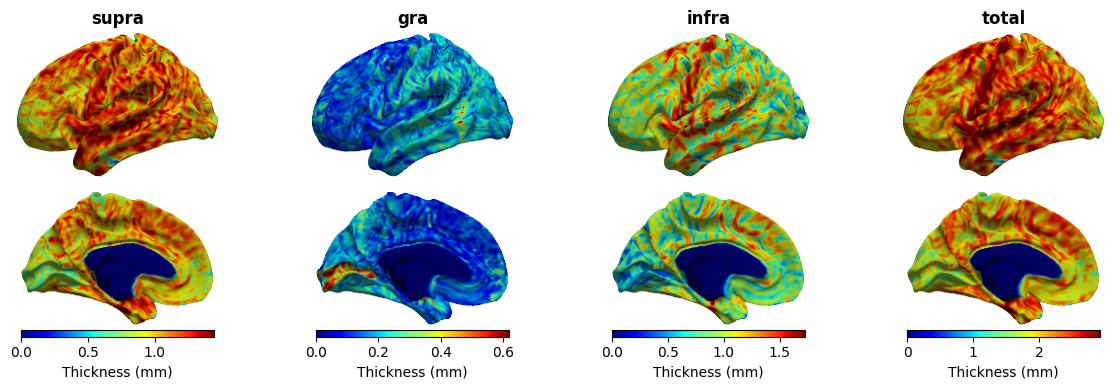

min: 0.000 max: 1.411
mean: 0.994 ± 0.299
min: 0.000 max: 0.648
mean: 0.160 ± 0.084
min: 0.000 max: 1.541
mean: 0.885 ± 0.338
min: 0.000 max: 3.118
mean: 2.025 ± 0.608


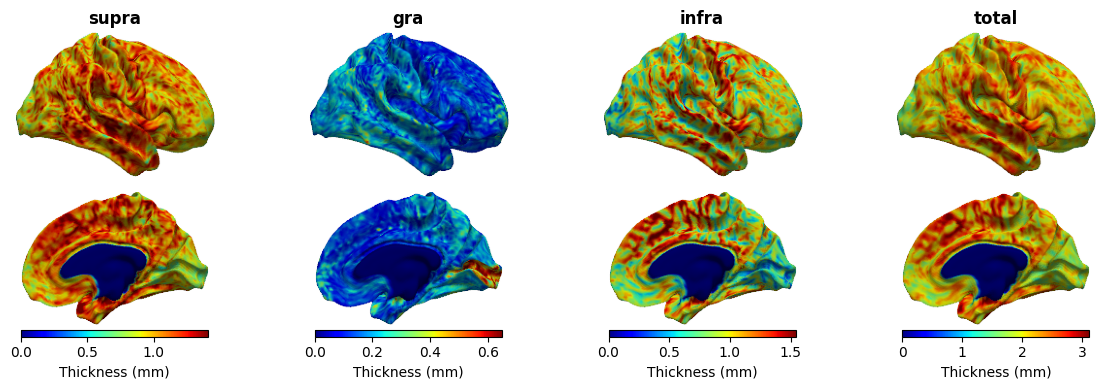

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

data2plot = layer_group_data#either layer_data or layer_group_data
# Plot each hemisphere
for k in ['lh','rh']:
    fig, axes = plt.subplots(2, len(data2plot), figsize=(len(data2plot)*3, 4))
    surf = lh_surf if k=='lh' else rh_surf
    
    # Plot each layer
    for i, layer_name in enumerate(data2plot.keys()):
        data = data2plot[layer_name][k]
        data_min = data.min()
        data_max = data.max()*0.8
        print('min:', f'{data_min:.3f}', 'max:', f'{data_max:.3f}')
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
        #calculate mean and std of data
        mean_data = data.mean()
        std_data = data.std()
        print('mean:', f'{mean_data:.3f}', '±', f'{std_data:.3f}')
        # Plot lateral and medial views
        for view_idx, view in enumerate(['lateral', 'medial']):
            plotter = yaspy.Plotter(surf, hemi=k)
            plotter.overlay(data, cmap='jet', alpha=1, vmin=data_min, vmax=data_max)
            plotter.border(data, alpha=0)
            img = plotter.screenshot(view)
            axes[view_idx,i].imshow(img)
            axes[view_idx,i].axis('off')
            
            if view_idx == 0:
                axes[0,i].set_title(layer_name, fontweight='bold')
            else:
                divider = make_axes_locatable(axes[1,i])
                cax = divider.append_axes("bottom", size="5%", pad=0.05)
                cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='jet'), 
                           cax=cax, orientation='horizontal')
                cbar.set_label('Thickness (mm)')

    plt.tight_layout()
    plt.show()


In [3]:
from sklearn.covariance import LedoitWolf, OAS, GraphicalLasso

 
def improved_partial_correlation_with_shrinkage(x):
    """
    Partial correlation with Ledoit-Wolf shrinkage applied consistently
    x: (n_features, n_samples) 
    Returns: (n_features, n_features) partial correlation matrix
    """
  
    n_features, n_samples = x.shape
    
    # Step 1: Handle NaN values
    x_clean = x.copy()
    for i in range(n_features):
        mask = np.isnan(x_clean[i, :])
        if mask.any():
            x_clean[i, mask] = np.nanmean(x_clean[i, :])
    
    # Step 2: Calculate mean across features for each sample
    x_mean = np.mean(x_clean, axis=0)  # Shape: (n_samples,)
    
    # Step 3: Create augmented data matrix
    # Transpose for sklearn: samples x features
    augmented_data = np.column_stack([x_clean.T, x_mean])  # Shape: (n_samples, n_features+1)
    
    # Step 4: Apply Ledoit-Wolf shrinkage
    #lw = LedoitWolf()
    #shrunk_cov = lw.fit(augmented_data).covariance_  # Shape: (n_features+1, n_features+1)
    oa = OAS()
    shrunk_cov = oa.fit(augmented_data).covariance_  # Shape: (n_features+1, n_features+1)
    # Convert to correlation matrix
    def cov_to_corr(cov):
        std = np.sqrt(np.diag(cov))
        return cov / np.outer(std, std)
    
    shrunk_corr = cov_to_corr(shrunk_cov)  # Shape: (n_features+1, n_features+1)
    
    # Step 5: Extract components for partial correlation
    r_ij = shrunk_corr[:n_features, :n_features]  # Shape: (n_features, n_features)
    r_ic = shrunk_corr[:n_features, -1]           # Shape: (n_features,)
    
    # Step 6: Calculate partial correlations
    r_icjc = np.outer(r_ic, r_ic)  # Shape: (n_features, n_features)
    denominator = np.sqrt(np.outer((1 - r_ic**2), (1 - r_ic**2)))  # Shape: (n_features, n_features)
    
    # Avoid division by zero
    denominator[denominator < np.finfo(float).eps] = np.finfo(float).eps
    
    partial_corr = (r_ij - r_icjc) / denominator  # Shape: (n_features, n_features)
    
    # Step 7: Clean up the matrix
    np.fill_diagonal(partial_corr, 0)
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    partial_corr = np.clip(partial_corr, -1, 1)
    
    return partial_corr  # Shape: (n_features, n_features) 

def calculate_partial_correlations(x):
    """
    Calculate partial correlations between regions while controlling for mean thickness.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Input data matrix with shape (n_regions, n_samples)
        
    Returns:
    --------
    partial_corr : numpy.ndarray
        Matrix of partial correlations between regions
    """
    # First get pairwise correlations between regions
    
    r_ij = np.corrcoef(x)
    # Calculate mean thickness across regions
    x_mean = np.nanmean(x, axis=0)
    # Get correlations between each region and the mean
    r_ic = np.corrcoef(x, x_mean[np.newaxis,:])[-1,:-1]
    
    # Calculate partial correlations controlling for mean
    # Formula: (r_ij - r_i,m * r_j,m) / sqrt((1-r_i,m^2)(1-r_j,m^2))
    # where r_i,m is correlation of region i with mean
    r_icjc = np.outer(r_ic, r_ic)
    partial_corr = (r_ij - r_icjc) / np.sqrt(np.outer((1-r_ic**2), (1-r_ic**2)))


    # zero out correlations of 1 (to avoid division by 0)
    partial_corr[np.isclose(partial_corr, 1)] = 0
    # Fisher z-transform the correlations
    #partial_corr = 0.5 * np.log((1 + partial_corr) / (1 - partial_corr))

    # Clean up any invalid values
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    
    return partial_corr


def calculate_correlation_matrix(data, transpose, partial_corr, shrink_it, first_index):
    """Calculate correlation matrix based on given parameters."""
    if transpose:
        data = data[first_index:].T
    else:
        data = data[first_index:]
        
    if partial_corr:
        corr = calculate_partial_correlations(data)
        if shrink_it:
            print('shrinkage')
            corr = improved_partial_correlation_with_shrinkage(data)
    else:
        corr = np.corrcoef(data)
        
    return corr

def plot_correlation_matrix(corr, transpose, title, radius):
    """Plot correlation matrix with consistent formatting."""
    # Remove diagonal values
    corr_plot = corr.copy()
    corr_plot[np.eye(corr_plot.shape[0], dtype=bool)] = np.nan
    
    # Plot matrix
    if transpose:
        im = plt.imshow(corr_plot, cmap='jet', vmin=0, vmax=1)
    else:
        im = plt.imshow(corr_plot, cmap='bwr')
        
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'{title}\nRadius {radius}mm')
    plt.xlabel('Subject')
    plt.ylabel('Subject')
    
    return corr

def plot_subject_similarity(hemisphere_data, radii, transpose=False, partial_corr=False, shrink_it=False):
    """
    Plot similarity matrices between subjects for different thickness measures and radii.
    
    Args:
        hemisphere_data (dict): Dictionary containing thickness data for one hemisphere
        radii (list): List of radius values used for smoothing
        transpose (bool): Whether to transpose the data matrices
        partial_corr (bool): Whether to calculate partial correlations
        shrink_it (bool): Whether to apply shrinkage to correlation calculation
    """
    # Initialize correlation dictionaries
    correlation_dicts = {
        'total': {},
        'infra': {},
        'supra': {},
        'relative': {},
        'proportional': {}
    }

    first_index = 1
    plt.figure(figsize=(len(correlation_dicts)*4,len(radii)*4))

    # Plot matrices for each radius
    for i, radius in enumerate(radii):
        # Define measures and their plot positions 
        measures = [
            ('total', 'Total Thickness', i+1),
            ('infra', 'WM to Inf Thickness', i+1+1),
            ('supra', 'Inf to Pial Thickness', i+1+2),
            ('relative', 'Relative Thickness', i+1+3),
            ('proportional', 'Proportional Thickness', i+1+4)
        ]
        
        # Plot each measure
        for measure, title, plot_pos in measures:
            print(len(radii), len(measures), plot_pos)
            plt.subplot(len(radii), len(measures), plot_pos)
            
            # Calculate correlation matrix
            corr = calculate_correlation_matrix(
                hemisphere_data[measure][i],
                transpose,
                partial_corr,
                shrink_it,
                first_index
            )
            
            # Store and plot correlation matrix
            correlation_dicts[measure][i] = plot_correlation_matrix(
                corr,
                transpose,
                title,
                radius
            )

    plt.tight_layout()
    
    return tuple(correlation_dicts[k] for k in ['total', 'infra', 'supra', 'relative', 'proportional'])



def parcellate_data(matrix, atlas, hemisphere):
    """Parcellate cortical layer data using a given atlas."""
    # Load atlas
    parcelIndices = atlas
    max_parcel_ind = int(np.max(parcelIndices))
    
    # Split indices by hemisphere
    if hemisphere == 'lh':
        parcelIndices = parcelIndices[0:32492]
    elif hemisphere == 'rh':
        parcelIndices = parcelIndices[32492:]
    
    # Initialize output array
    parcellated = []
    
    # Parcellate data for each subject
    for subject_idx in range(matrix.shape[0]):
        m = int(max_parcel_ind/2)+1
        #m = 180+1 #for glasser or deikan (35)
       # m = 35+1;#desikan
        # Initialize array for this hemisphere's parcels
        subject_data = np.zeros(m)
        
        # Get subject's data
        data = matrix[subject_idx]
        
        # Set parcel range based on hemisphere
        if hemisphere == 'lh':
            parcel_range = range(1, m)
        elif hemisphere == 'rh':
            parcel_range = range(m, max_parcel_ind+1)
            #parcel_range = range(1,m) #for glasser or deikan
            
        # Calculate mean for each parcel
        for k in parcel_range:
            mask = parcelIndices == k
            if np.sum(mask) > 0:
                # Use trimmed mean with 10% trim on both ends
                # Science advances paper, "structural covariance, Parcellation Approach in Methods"
                parcel_idx = k if hemisphere == 'lh' else k-m+1
                #parcel_idx = k  #for glasser or deikan
                subject_data[parcel_idx] = scipy.stats.trim_mean(data[mask][~np.isnan(data[mask])], proportiontocut=0.1)
                #subject_data[parcel_idx] = np.nanmedian(data[mask])
                
        # Append subject's parcellated data
        parcellated.append(subject_data)
            
    # Convert list to numpy array
    return np.vstack(parcellated)


In [4]:
data_types = ['infra', 'supra', 'gra', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'relative', 'total','proportional']
hemispheres = {'lh': 'left', 'rh': 'right'}

# Initialize dictionaries
data = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}



for hemi in hemispheres:
    if os.path.exists(f'{baseDir}/{hemi}.0-6.32k.shape.gii'):
        # Load thickness data
        print(hemi)
        thickness_data = {
            #nib.load(os.path.join(baseDir, 'lh.0-3.32k.shape.gii')).darrays[0].data,
            
            'supra': nib.load(f'{baseDir}/{hemi}.0-3.32k.shape.gii').darrays[0].data,
            'gra': nib.load(f'{baseDir}/{hemi}.3-4.32k.shape.gii').darrays[0].data,
            'infra': nib.load(f'{baseDir}/{hemi}.4-6.32k.shape.gii').darrays[0].data,
            'total': nib.load(f'{baseDir}/{hemi}.0-6.32k.shape.gii').darrays[0].data,
            'L1': nib.load(f'{baseDir}/{hemi}.0-1.32k.shape.gii').darrays[0].data,
            'L2': nib.load(f'{baseDir}/{hemi}.1-2.32k.shape.gii').darrays[0].data,
            'L3': nib.load(f'{baseDir}/{hemi}.2-3.32k.shape.gii').darrays[0].data,
            'L4': nib.load(f'{baseDir}/{hemi}.3-4.32k.shape.gii').darrays[0].data,
            'L5': nib.load(f'{baseDir}/{hemi}.4-5.32k.shape.gii').darrays[0].data,
            'L6': nib.load(f'{baseDir}/{hemi}.5-6.32k.shape.gii').darrays[0].data,
        }

        thickness_data['relative'] = thickness_data['supra'] / thickness_data['infra']
        #set thickness_data['relative'] to 0 if it is nan
        thickness_data['relative'][np.isnan(thickness_data['relative'])] = 0
        thickness_data['relative'][np.isinf(thickness_data['relative'])] = 0

        #for proportional (which is total infragranular layer over total thickness)
        thickness_data['proportional'] = thickness_data['infra'] / thickness_data['total']
        thickness_data['proportional'][np.isnan(thickness_data['proportional'])] = 0
        thickness_data['proportional'][np.isinf(thickness_data['proportional'])] = 0

        #should i normalize here?
        # Process each data type
        for dtype in data_types:
            reshaped_data = thickness_data[dtype].reshape(-1, 1)
            if len(data[hemi][dtype]) == 0:
                data[hemi][dtype] = reshaped_data
            else:
                data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped_data), axis=1)
        
        # Clean up relative thickness data
        data[hemi]['relative'][np.isnan(data[hemi]['relative'])] = 0
        data[hemi]['relative'][np.isinf(data[hemi]['relative'])] = 0

# Rename variables to match rest of code
lh_data = data['lh']
rh_data = data['rh']

lh
rh


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_58513/302699799.py:28: RuntimeWarning: invalid value encountered in divide
  thickness_data['relative'] = thickness_data['supra'] / thickness_data['infra']
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_58513/302699799.py:34: RuntimeWarning: invalid value encountered in divide
  thickness_data['proportional'] = thickness_data['infra'] / thickness_data['total']


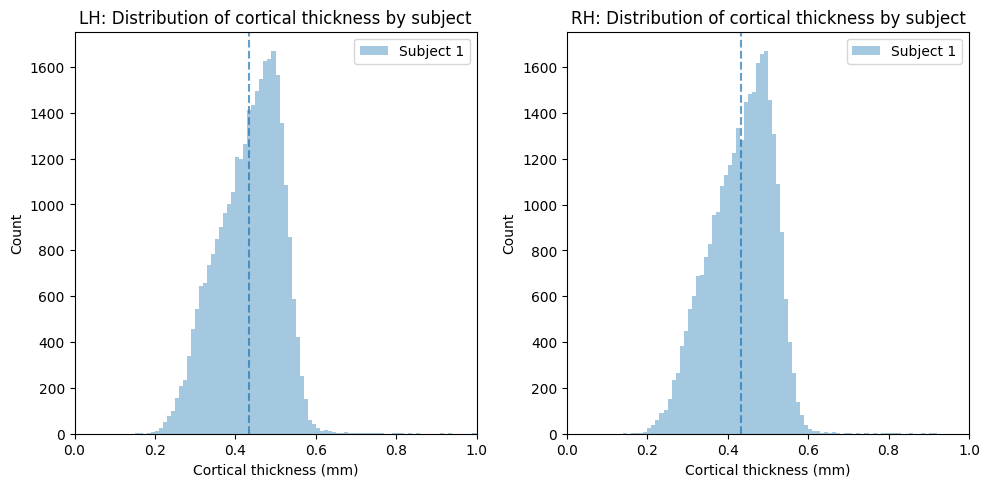

In [5]:
# Create histograms for smoothed data from both hemispheres for each subject
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

layer_type = 'proportional'

if layer_type == 'total':
    xlimit = (0,1) if normalize_data else (0,4)
    xlabel = 'Cortical thickness (mm)'
    title = 'Distribution of cortical thickness by subject'
elif layer_type == 'relative':
    xlimit = (0,1) if normalize_data else (0,3)
    xlabel = 'Relative cortical thickness'
    title = 'Distribution of relative cortical thickness by subject'
elif layer_type == 'infra' or layer_type == 'supra':
    xlimit = (0,2) if normalize_data else (0,2)
    xlabel = 'Cortical thickness (mm)'
    title = 'Distribution of cortical thickness by subject'
elif layer_type == 'proportional':
    xlimit = (0,1)
    xlabel = 'Proportional cortical thickness'
    title = 'Distribution of proportional cortical thickness by subject'

# Transpose data to get shape (11, 32491) so each row is a subject
lh_data_by_subject = lh_data[layer_type].T
rh_data_by_subject = rh_data[layer_type].T

# Plot histogram for each subject for left hemisphere
for i in range(lh_data_by_subject.shape[0]):
    # Remove zeros from the data
    non_zero_data = lh_data_by_subject[i][lh_data_by_subject[i] != 0]
    hist = ax1.hist(non_zero_data, bins=100, range=xlimit, alpha=0.4, label=f'Subject {i+1}')
    # Add vertical line for mean using the color of the last histogram
    mean = np.mean(non_zero_data)
    ax1.axvline(x=mean, color=hist[2][0].get_facecolor(), linestyle='--', alpha=0.7)

ax1.set_xlabel('Cortical thickness (mm)')
ax1.set_ylabel('Count')
ax1.set_title('LH: Distribution of cortical thickness by subject')
ax1.legend()
ax1.set_xlim(xlimit)

# Plot histogram for each subject for right hemisphere
for i in range(rh_data_by_subject.shape[0]):
    # Remove zeros from the data
    non_zero_data = rh_data_by_subject[i][rh_data_by_subject[i] != 0]
    hist = ax2.hist(non_zero_data, bins=100, range=xlimit, alpha=0.4, label=f'Subject {i+1}')
    # Add vertical line for mean using the color of the last histogram
    mean = np.mean(non_zero_data)
    ax2.axvline(x=mean, color=hist[2][0].get_facecolor(), linestyle='--', alpha=0.7)

ax2.set_xlabel('Cortical thickness (mm)')
ax2.set_ylabel('Count')
ax2.set_title('RH: Distribution of cortical thickness by subject')
ax2.legend()
ax2.set_xlim(xlimit)


# Make plots square by setting aspect ratio
ax1.set_aspect(1.0/ax1.get_data_ratio())
ax2.set_aspect(1.0/ax2.get_data_ratio())

plt.tight_layout()
plt.show()

In [6]:
def process_hemisphere_data(data, atlas, hemi):
    """
    Process hemisphere data by parcellating metrics and calculating derived measures
    
    Parameters:
    -----------
    data : dict
        Dictionary containing hemisphere data with metrics like 'total', 'infra', etc
    atlas : array-like
        Atlas data for parcellation
    hemi: str, 'lh' or 'rh' 
    Returns:
    --------
    dict : Processed and parcellated data
    """
    # Initialize output dictionary
    data_parc = {
        'total': [], 'infra': [], 'supra': [], 'gra': [], 'relative': [], 'proportional': [],
        'L1': [], 'L2': [], 'L3': [], 'L4': [], 'L5': [], 'L6': []
    }

    # Parcellate basic metrics
    for metric in ['total', 'infra', 'supra', 'gra']:
        data_parc[metric] = parcellate_data(data[metric].T, atlas, hemi).T

    # Parcellate individual layers
    for layer in ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']:
        data_parc[layer] = parcellate_data(data[layer].T, atlas, hemi).T

    # Calculate relative and proportional metrics
    data_parc['relative'] = data_parc['supra'] / data_parc['infra']
    data_parc['proportional'] = data_parc['infra'] / data_parc['total']

    # Clean up invalid values
    for metric in ['relative', 'proportional']:
        data_parc[metric][data_parc[metric] == np.inf] = 0
        data_parc[metric][data_parc[metric] == np.nan] = 0

    return data_parc



#plot the data

In [7]:
def process_hemisphere_parcellation(lh_data_parc, rh_data_parc, atlas):
    """
    Process left and right hemisphere parcellation data using an atlas
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict 
        Right hemisphere parcellation data
    atlas : array-like
        Atlas data for mapping
        
    Returns:
    --------
    tuple : Processed left and right hemisphere data
    """
    # Process left hemisphere data
    for key in lh_data_parc.keys():
        mask_lh = atlas[:32492] != 0
        min_atlas = np.min(atlas[:32492][atlas[:32492] != 0])
        max_atlas = np.max(atlas[:32492][atlas[:32492] != 0])
        lh_data_parc[key] = map_to_labels(lh_data_parc[key].ravel()[1:], atlas[:32492], 
                                         mask=mask_lh, fill=np.nan,
                                         source_lab=np.arange(min_atlas, max_atlas+1))
        #lh_data_parc[key] = map_to_labels(lh_data_parc[key].ravel(), atlas[:32492], 
        #                                mask=None, fill=np.nan,
        #                                 source_lab=np.concatenate(([0], np.arange(min_atlas, max_atlas+1))))

    # Process right hemisphere data 
    for key in rh_data_parc.keys():
        mask_rh = atlas[32492:] != 0
        min_atlas = np.min(atlas[32492:][atlas[32492:] != 0])
        max_atlas = np.max(atlas[32492:][atlas[32492:] != 0])
        rh_data_parc[key] = map_to_labels(rh_data_parc[key].ravel()[1:], atlas[32492:],
                                         mask=mask_rh, fill=np.nan,
                                         source_lab=np.arange(min_atlas, max_atlas+1))
        #rh_data_parc[key] = map_to_labels(rh_data_parc[key].ravel(), atlas[32492:],
        #                                 mask=None, fill=np.nan,
        #                                 source_lab=np.concatenate(([0], np.arange(min_atlas, max_atlas+1))))
        
    return lh_data_parc, rh_data_parc


In [8]:
def combine_hemispheres_data(lh_data_parc, rh_data_parc):
    """
    Combine left and right hemisphere data into grouped dictionaries and fill NaN values with means
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict
        Right hemisphere parcellation data
        
    Returns:
    --------
    tuple : Three dictionaries containing grouped layer data:
            - layer_group_parc: Combined supra/gra/infra/total thickness data
            - layer_ind_parc: Individual layer (L1-L6) thickness data  
            - layer_extra_parc: Relative and proportional thickness metrics
    """
    # Combine hemisphere data into groups
    layer_group_parc = {
        'supra': {'lh': lh_data_parc['supra'], 'rh': rh_data_parc['supra']},
        'gra': {'lh': lh_data_parc['gra'], 'rh': rh_data_parc['gra']},
        'infra': {'lh': lh_data_parc['infra'], 'rh': rh_data_parc['infra']},
        'total': {'lh': lh_data_parc['total'], 'rh': rh_data_parc['total']},
    }

    layer_ind_parc = {
        'L1': {'lh': lh_data_parc['L1'], 'rh': rh_data_parc['L1']},
        'L2': {'lh': lh_data_parc['L2'], 'rh': rh_data_parc['L2']},
        'L3': {'lh': lh_data_parc['L3'], 'rh': rh_data_parc['L3']},
        'L4': {'lh': lh_data_parc['L4'], 'rh': rh_data_parc['L4']},
        'L5': {'lh': lh_data_parc['L5'], 'rh': rh_data_parc['L5']},
        'L6': {'lh': lh_data_parc['L6'], 'rh': rh_data_parc['L6']},
    }

    layer_extra_parc = {
        'relative': {'lh': lh_data_parc['relative'], 'rh': rh_data_parc['relative']},
        'proportional': {'lh': lh_data_parc['proportional'], 'rh': rh_data_parc['proportional']},
    }

    # Fill NaN values with means
    for key in layer_group_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_group_parc[key][hemi][np.isnan(layer_group_parc[key][hemi])] = np.mean(layer_group_parc[key][hemi][~np.isnan(layer_group_parc[key][hemi])])

    for key in layer_ind_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_ind_parc[key][hemi][np.isnan(layer_ind_parc[key][hemi])] = np.mean(layer_ind_parc[key][hemi][~np.isnan(layer_ind_parc[key][hemi])])

    for key in layer_extra_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_extra_parc[key][hemi][np.isnan(layer_extra_parc[key][hemi])] = np.mean(layer_extra_parc[key][hemi][~np.isnan(layer_extra_parc[key][hemi])])

    return layer_group_parc, layer_ind_parc, layer_extra_parc

In [9]:
# Process left and right hemisphere data

lh_parc100, rh_parc100 = process_hemisphere_parcellation(process_hemisphere_data(lh_data,atlas_schaefer100,'lh'),process_hemisphere_data(rh_data,atlas_schaefer100,'rh'), atlas_schaefer100)
group_parc100, ind_parc100, extra_parc100 = combine_hemispheres_data(lh_parc100, rh_parc100)

lh_parc400, rh_parc400 = process_hemisphere_parcellation(process_hemisphere_data(lh_data,atlas_schaefer400,'lh'),process_hemisphere_data(rh_data,atlas_schaefer400,'rh'), atlas_schaefer400)
group_parc400, ind_parc400, extra_parc400 = combine_hemispheres_data(lh_parc400, rh_parc400)

lh_parc1000, rh_parc1000 = process_hemisphere_parcellation(process_hemisphere_data(lh_data,atlas_schaefer1000,'lh'),process_hemisphere_data(rh_data,atlas_schaefer1000,'rh'), atlas_schaefer1000)
group_parc1000, ind_parc1000, extra_parc1000 = combine_hemispheres_data(lh_parc1000, rh_parc1000)


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_58513/3367940180.py:31: RuntimeWarning: invalid value encountered in divide
  data_parc['relative'] = data_parc['supra'] / data_parc['infra']
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_58513/3367940180.py:32: RuntimeWarning: invalid value encountered in divide
  data_parc['proportional'] = data_parc['infra'] / data_parc['total']


In [10]:
print(lh_data['infra'].shape)

(32492, 1)


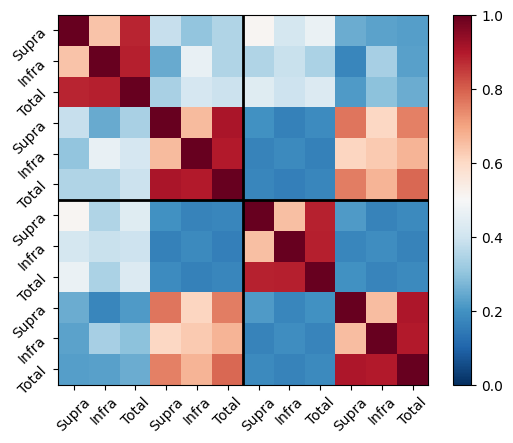

In [14]:
#need to calculate correlation coefficient for group_parc1000
#combine data across all group_parcs by change no np.array to np.stack 
group_parc_all = np.stack([
                           #left hemi supra
                           group_parc1000['supra']['lh'],
                           group_parc1000['infra']['lh'],
                           group_parc1000['total']['lh'],
                           layer_group_data['supra']['lh'],
                           layer_group_data['infra']['lh'],
                           layer_group_data['total']['lh'],
                           #right hemi supra
                           group_parc1000['supra']['rh'],
                           group_parc1000['infra']['rh'],
                           group_parc1000['total']['rh'],
                           layer_group_data['supra']['rh'],
                           layer_group_data['infra']['rh'],
                           layer_group_data['total']['rh']])

#perform correlation across the first dimension of group_parc_all
# np.corrcoef will return a 12x12 correlation matrix since group_parc_all has shape (12, 32492)
# Each row will be correlated with every other row
tmp_corr = np.corrcoef(group_parc_all)
#set diagonal to 0

plt.imshow(tmp_corr, vmin=0, vmax=1, cmap='RdBu_r')
#draw line at the middle xine and ylien
plt.axvline(x=len(group_parc_all)/2-0.5, color='black', linestyle='-',linewidth=2)
plt.axhline(y=len(group_parc_all)/2-0.5, color='black', linestyle='-',linewidth=2)
#for x tick put s,i,g and repeat for y tick
plt.xticks(np.arange(len(group_parc_all)), ['Supra', 'Infra', 'Total', 'Supra', 'Infra', 'Total']*2, fontsize=10, rotation=45)
plt.yticks(np.arange(len(group_parc_all)), ['Supra', 'Infra', 'Total', 'Supra', 'Infra', 'Total']*2, fontsize=10, rotation=45)
# Add labels for groups of 3 ticks



plt.colorbar()
plt.show()

min: 0.739 max: 1.301
mean: 1.065 ± 0.102
min: 0.093 max: 0.469
mean: 0.175 ± 0.050
min: 0.544 max: 1.426
mean: 0.966 ± 0.146
min: 1.601 max: 2.831
mean: 2.195 ± 0.219


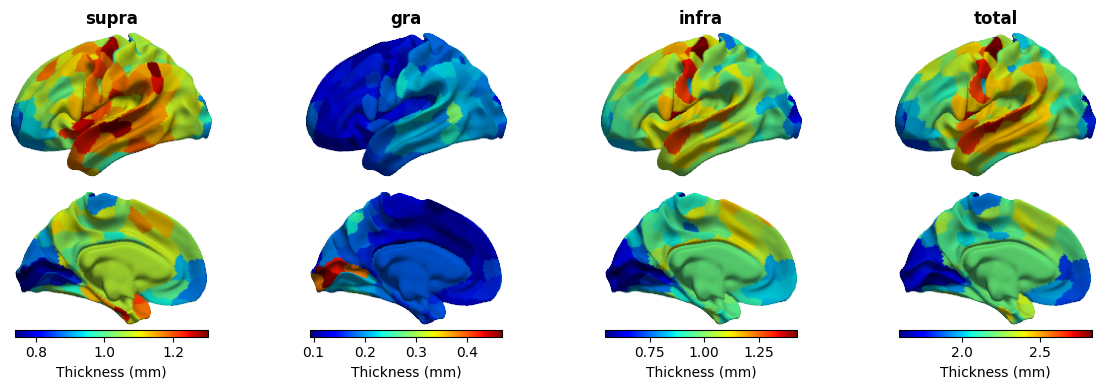

min: 0.756 max: 1.277
mean: 1.057 ± 0.095
min: 0.095 max: 0.495
mean: 0.169 ± 0.054
min: 0.586 max: 1.338
mean: 0.948 ± 0.138
min: 1.634 max: 2.637
mean: 2.162 ± 0.197


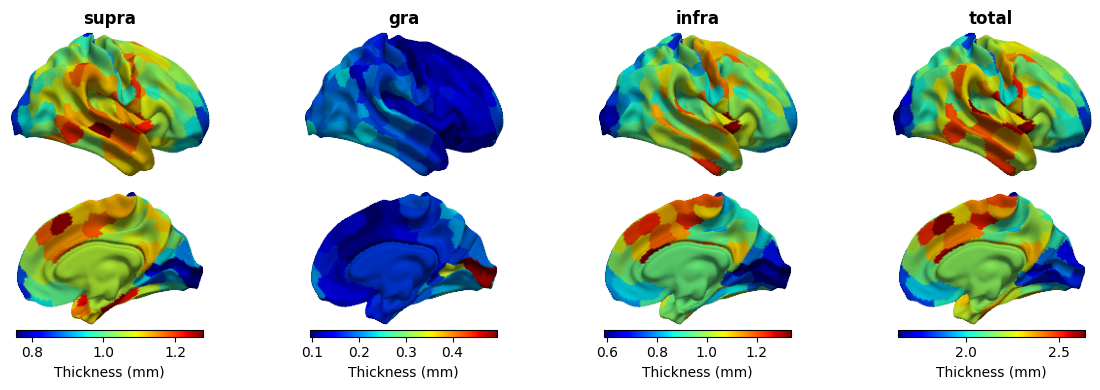

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

data2plot = group_parc400#either layer_data or layer_group_data
# Plot each hemisphere
for k in ['lh','rh']:
    fig, axes = plt.subplots(2, len(data2plot), figsize=(len(data2plot)*3, 4))
    surf = lh_surf if k=='lh' else rh_surf
    
    # Plot each layer
    for i, layer_name in enumerate(data2plot.keys()):
        data = data2plot[layer_name][k]
        data_min = data.min()
        data_max = data.max()
        cmap = 'jet'
        cbar_label = 'Thickness (mm)'
        if layer_name   ==  'relative':
            data_min = 0.8
            data_max = 1.2
            cmap = 'RdBu'
            cbar_label = 'Relative thickness (supra/infra)'
        elif layer_name == 'proportional':
            data_min = 0.4
            data_max = 0.6
            cmap = 'RdBu'
            cbar_label = 'Proportional thickness (infra/total)'

        print('min:', f'{data_min:.3f}', 'max:', f'{data_max:.3f}')
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
        #calculate mean and std of data
        mean_data = data.mean()
        std_data = data.std()
        print('mean:', f'{mean_data:.3f}', '±', f'{std_data:.3f}')
        # Plot lateral and medial views
        for view_idx, view in enumerate(['lateral', 'medial']):
            plotter = yaspy.Plotter(surf, hemi=k)
            plotter.overlay(data, cmap=cmap, alpha=1, vmin=data_min, vmax=data_max)
            plotter.border(data, alpha=0)
            img = plotter.screenshot(view)
            axes[view_idx,i].imshow(img)
            axes[view_idx,i].axis('off')
            
            if view_idx == 0:
                axes[0,i].set_title(layer_name, fontweight='bold')
            else:
                divider = make_axes_locatable(axes[1,i])
                cax = divider.append_axes("bottom", size="5%", pad=0.05)
                cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                           cax=cax, orientation='horizontal')
                cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()
